In [1]:
from functools import partial

from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from pit import *

In [2]:
%matplotlib widget

In [3]:
def pit_hist(ax, x, n_bins, **kwargs):
    ax.hist(x, range=(0, 1), bins=n_bins, **kwargs)

def pit_stairs(ax, x, n_bins, **kwargs):
    ax.stairs(x, np.linspace(0, 1, n_bins + 1), **kwargs)

In [4]:
def get_grid():
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(2, 2)
    ax = fig.add_subplot(gs[0, :])
    ax_true = fig.add_subplot(gs[1, 0])
    ax_pred = fig.add_subplot(gs[1, 1])
    return fig, ax, ax_true, ax_pred

def plot_pred_press(event, ax, model, plot_function):
    x = float(event.xdata)
    y = float(event.ydata)
    if x is not None and y is not None:
        ax.clear()
        reconstruction = model.decoder.decode(torch.tensor([[x, y]]))[0]
        plot_function(ax, reconstruction, label=f"({x:.4f}, {y:.4f})")
        ax.legend()
        fig.canvas.draw()

def plot_true_pick(event, ax_true, ax_pred, data_set, model, plot_function):
    idx = event.ind[0]
    # true
    ax_true.clear()
    x, y = data_set.X[idx], data_set.y[idx]
    plot_function(ax_true, x, label=repr(y))
    ax_true.legend()
    # reconstruction
    #ax_pred.clear()
    mus, sigmas = model.embed(x.unsqueeze(0))
    reconstruction = model.decoder.decode(mus)[0]
    plot_function(ax_true, reconstruction, label=mus)
    ax_pred.legend() # TODO label with embed
    fig.canvas.draw()

## Data

In [5]:
seed()
n_repeats, n_samples = 1, 1000
train_data = generate_data(n_repeats, n_samples)
test_data = generate_data(n_repeats, n_samples)
colors = ["red" if type(a[1]) is Normal else "green" for a in train_data[1]]

In [6]:
BINS = 10
train_set, test_set = PITHistDataset(*train_data, BINS), PITHistDataset(*test_data, BINS)

## Variational AutoEncoder

In [7]:
vae = VAE(input_dim=BINS, n_hiddens=8, epsilon=None)
vae.load_state_dict(torch.load("models/fresh-voice-4294.pt"))
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): Tanh()
      (4): Linear(in_features=8, out_features=10, bias=True)
      (5): Softmax(dim=1)
    )
  )
)

In [8]:
mus_train, sigmas_train = vae.embed(train_set.X)
X_pred_train = vae.decoder.decode(mus_train)

In [9]:
loss_rec = square_error(X_pred_train, train_set.X)
loss_rec.max(), torch.argmax(loss_rec)

(tensor(0.0304), tensor(70))

(array([39., 27.,  4.,  6.,  0.,  0.,  1.,  1.,  1.,  1.]),
 array([0.03749845, 0.05016739, 0.06283633, 0.07550527, 0.08817422,
        0.10084316, 0.1135121 , 0.12618104, 0.13884997, 0.15151893,
        0.16418786]),
 <BarContainer object of 10 artists>)

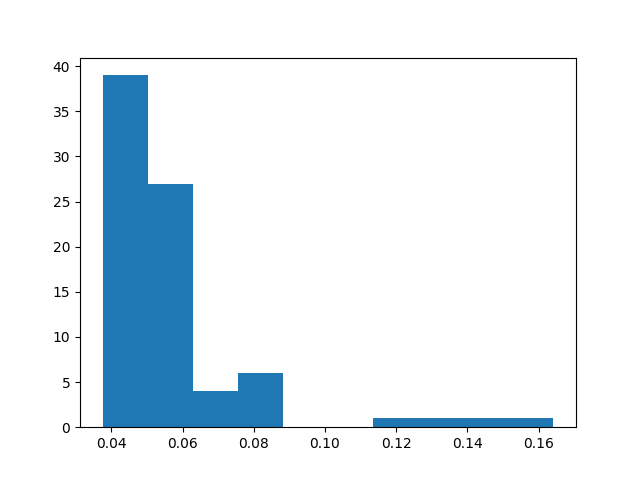

In [10]:
_, ax = plt.subplots()
ax.hist(sigmas_train[:, 0])

16

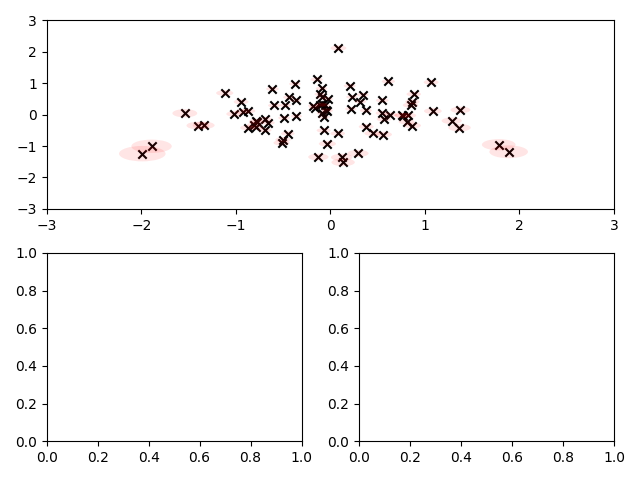

In [11]:
fig, ax, ax_true, ax_pred = get_grid()
ax.scatter(mus_train[:, 0], mus_train[:, 1], c="k", marker="x", picker=True)
ells = [Ellipse(xy=mus_train[i],
                width=(3 * sigmas_train[i]),
                height=(3 * sigmas_train[i])) for i in range(mus_train.shape[0])]

for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor("r")

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

#ax.scatter(mus_test[:, 0], mus_test[:, 1], marker="*", s=100, c="black")

plot_function = partial(pit_stairs, n_bins=BINS)
fig.canvas.mpl_connect(
    "pick_event",
    partial(plot_true_pick,
            ax_true=ax_true, ax_pred=ax_pred,
            data_set=train_set, model=vae,
            plot_function=plot_function))
fig.canvas.mpl_connect(
    "button_press_event",
    partial(plot_pred_press, ax=ax_pred, model=vae, plot_function=plot_function))

## AutoEncoder

In [ ]:
BINS = 64
encoder = EncoderDecoder(input_dim=BINS, n_hiddens=16, embed_dim=2)
encoder.load_state_dict(torch.load("models/lyric-sweep-259.pt"))

In [ ]:
BINS = 8
encoder = EncoderDecoder(input_dim=BINS, n_hiddens=64, embed_dim=2)
encoder.load_state_dict(torch.load("models/amber-sweep-70.pt"))

In [ ]:
BINS = 8
encoder = EncoderDecoder(input_dim=BINS, n_hiddens=64, embed_dim=4)
encoder.load_state_dict(torch.load("models/absurd-sweep-2093.pt"))

In [ ]:
train_embeds = encoder.embed(train_set.X)
test_embeds = encoder.embed(test_set.X)
train_embeds.shape, test_embeds.shape

In [ ]:
fig, ax, ax_true, ax_pred = get_grid()
ax.scatter(train_embeds[:, 0], train_embeds[:, 1], c=colors, alpha=0.5, picker=True)
ax.scatter(test_embeds[:, 0], test_embeds[:, 1], marker="*", s=100, c="black")

plot_function = partial(pit_stairs, n_bins=BINS)
fig.canvas.mpl_connect(
    "pick_event",
    partial(plot_true_pick,
            ax_true=ax_true, ax_pred=ax_pred,
            data_set=train_set, model=encoder,
            plot_function=plot_function))
#fig.canvas.mpl_connect(
#    "button_press_event",
#    partial(plot_pred_press, ax=ax_pred, model=encoder, plot_function=plot_function))

## Embedder

In [ ]:
train_set, test_set = PITValuesDataset(*train_data), PITValuesDataset(*test_data)

embedder = EmbedderDecoder(len(train_set), embed_dim=2, n_hiddens=4, output_dim=256)
embedder.load_state_dict(torch.load("models/curious-sweep-129.pt"))
embedder

In [ ]:
train_embeds = embedder.embed(torch.arange(len(train_set)))
hyperparams = {"bs": 32, "lr": 0.1, "patience": 100}
test_embedder = embedder.new_data_set(test_set, hyperparams)
test_embeds = test_embedder.embed(torch.arange(len(test_set)))

In [ ]:
fig, ax, ax_true, ax_pred = get_grid()
ax.scatter(train_embeds[:, 0], train_embeds[:, 1], c=colors, alpha=0.5, picker=True)
ax.scatter(test_embeds[:, 0], test_embeds[:, 1], marker="*", s=100, c="black")

plot_function = partial(pit_hist, n_bins=20)
fig.canvas.mpl_connect(
    "button_press_event",
    partial(plot_pred_press, ax=ax_pred, model=embedder, plot_function=plot_function))
fig.canvas.mpl_connect(
    "pick_event",
    partial(plot_true_pick, ax=ax_true, data_set=train_set, plot_function=plot_function))